In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from clr_gat_rerep import CLRGATREP
from dataloaders import UnlabelledDataset

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
model = CLRGATREP.load_from_checkpoint("/home/ojass/projects/ckpts/clr_gat_66.ckpt", pretrain_re_rep=True)

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'feature_extractor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['feature_extractor'])`.
  rank_zero_warn(


MultiHeadDotProduct


/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [3]:
ds = UnlabelledDataset("miniimagenet", "/home/ojass/projects/unsupervised-meta-learning/data/untarred/", split="train", n_support=1, n_query=3, no_aug_support=True, img_size_orig=[84, 84])

In [4]:
from torch.utils.data import DataLoader

In [5]:
dl = DataLoader(ds, shuffle=True, num_workers=1, batch_size=64)

In [6]:
idl = iter(dl)

In [7]:
xs = next(idl)

In [8]:
s, q, l = xs["origs"], xs["views"], xs["labels"]

In [9]:
s_labels = l[:, 0]

In [10]:
x = torch.cat([s, q], dim=1)

In [11]:
import einops

In [12]:
x.shape

torch.Size([64, 4, 3, 84, 84])

In [13]:
x = einops.rearrange(x, 'b q c h w -> (b q) c h w')

In [14]:
x = x.cuda()

In [15]:
model = model.to("cuda")

In [16]:
z_cnn, z = model.mpnn_forward(x)

In [19]:
from umap import UMAP
from sklearn.manifold import TSNE

In [22]:
r = UMAP().fit_transform(z.cpu().detach().numpy())

In [27]:
import pandas as pd

In [29]:
c1, c2 = l.flatten().unique(return_counts=True)
df = pd.DataFrame({"label": c1, "count": c2})
df.head()

,label,count
0,0,4
1,1,16
2,2,4
3,7,4
4,8,4


In [31]:
df[df["count"] > 4]

,label,count
1,1,16
6,14,12
19,33,8
22,38,8
23,39,16
24,41,8
26,43,16
28,46,16
31,50,8
32,51,8


<AxesSubplot:>

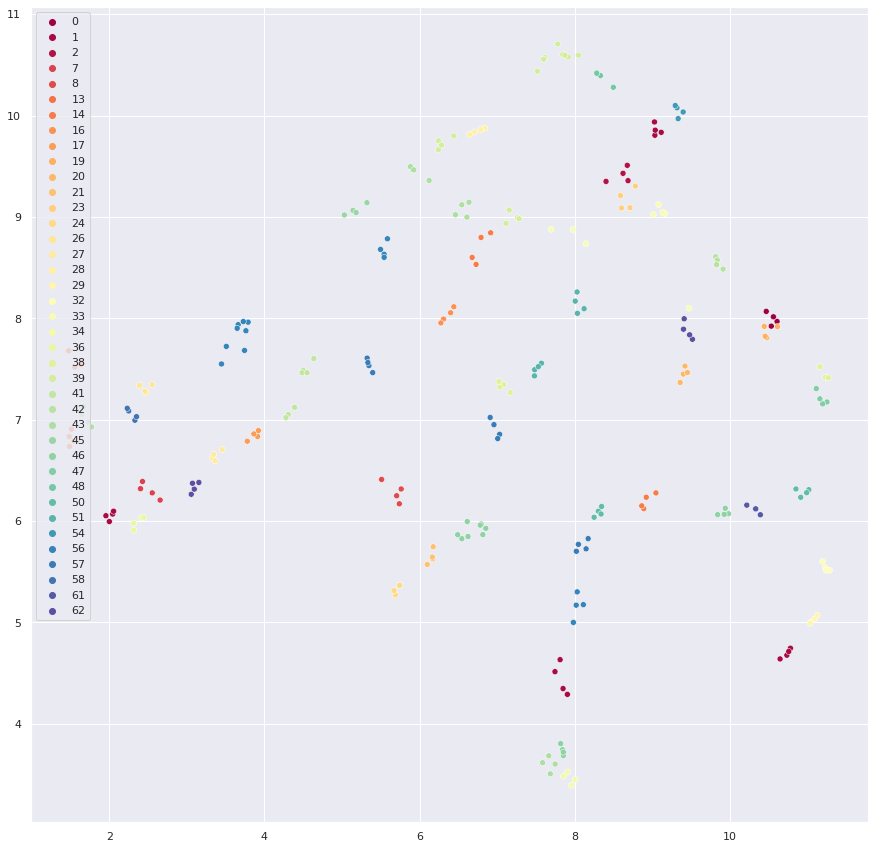

In [35]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=l.flatten().cpu().numpy(), palette="Spectral", legend="full")

In [36]:
r = TSNE().fit_transform(z.cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

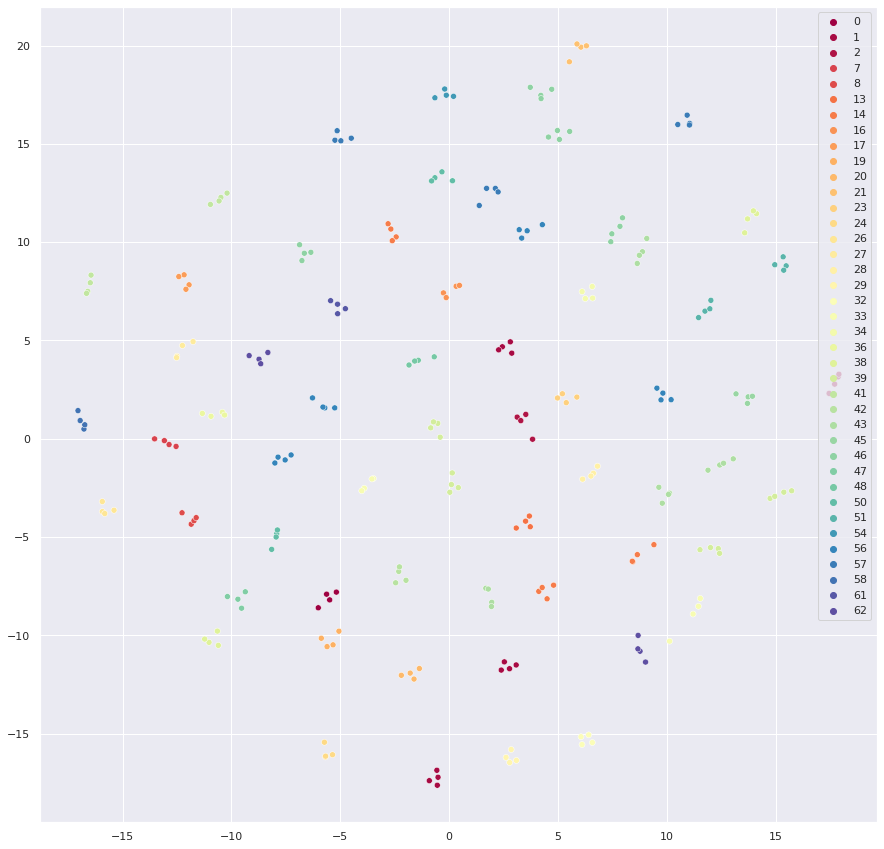

In [37]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=l.flatten().cpu().numpy(), palette="Spectral", legend="full")

In [38]:
z_supp, z_query = model.re_represent(z, 64, 0.5, 0.5, 0.1)

In [39]:
z = torch.cat([z_supp, z_query])

In [40]:
r = TSNE().fit_transform(z.cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

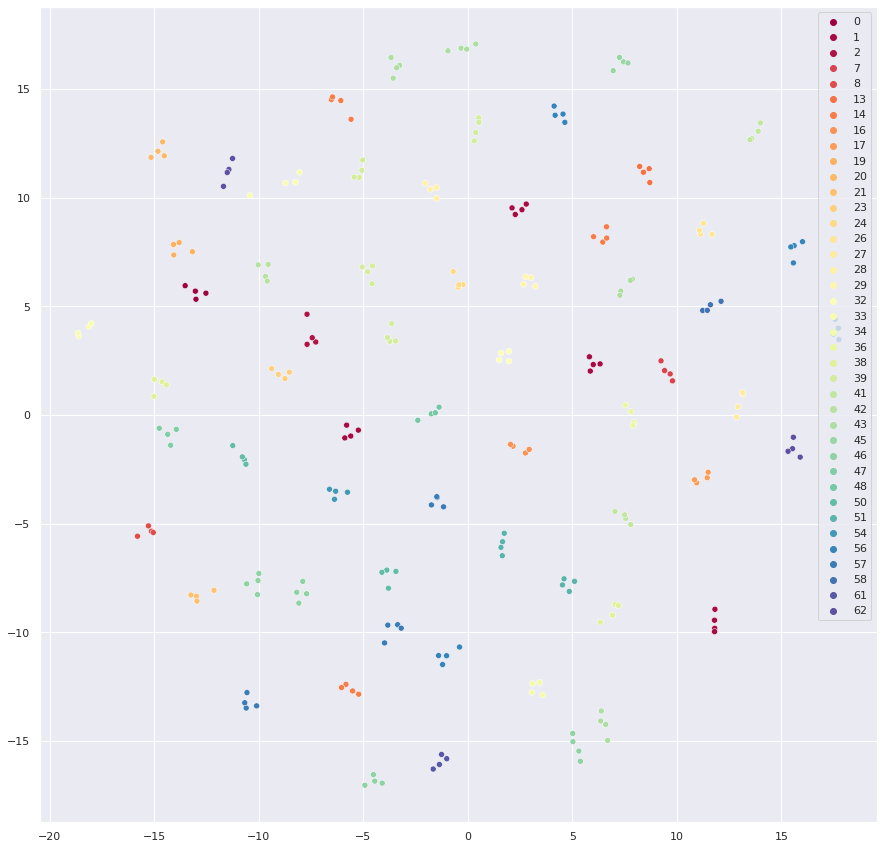

In [42]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=l.flatten().cpu().numpy(), palette="Spectral", legend="full")

In [43]:
from dataloaders import get_episode_loader

In [45]:
dl = get_episode_loader("miniimagenet", "/home/ojass/projects/unsupervised-meta-learning/data/untarred/", ways=5, shots=5, test_shots=15, batch_size=1, split="train")

Supervised data loader for miniimagenet:train.


In [46]:
idl = iter(dl)

In [47]:
xs = next(idl)

In [49]:
train = xs["train"]
test = xs["test"]

In [54]:
x_train = train[0][0]

In [58]:
y_train = train[1][0]

In [59]:
y_train

tensor([4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 0, 0,
        0])

In [63]:
x_test = test[0][0]
y_test = test[1][0]

In [64]:
x = torch.cat([x_train, x_test])

In [67]:
z = model(x.cuda())

In [69]:
r = TSNE().fit_transform(z.cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [70]:
y = torch.cat([y_train, y_test])

<AxesSubplot:>

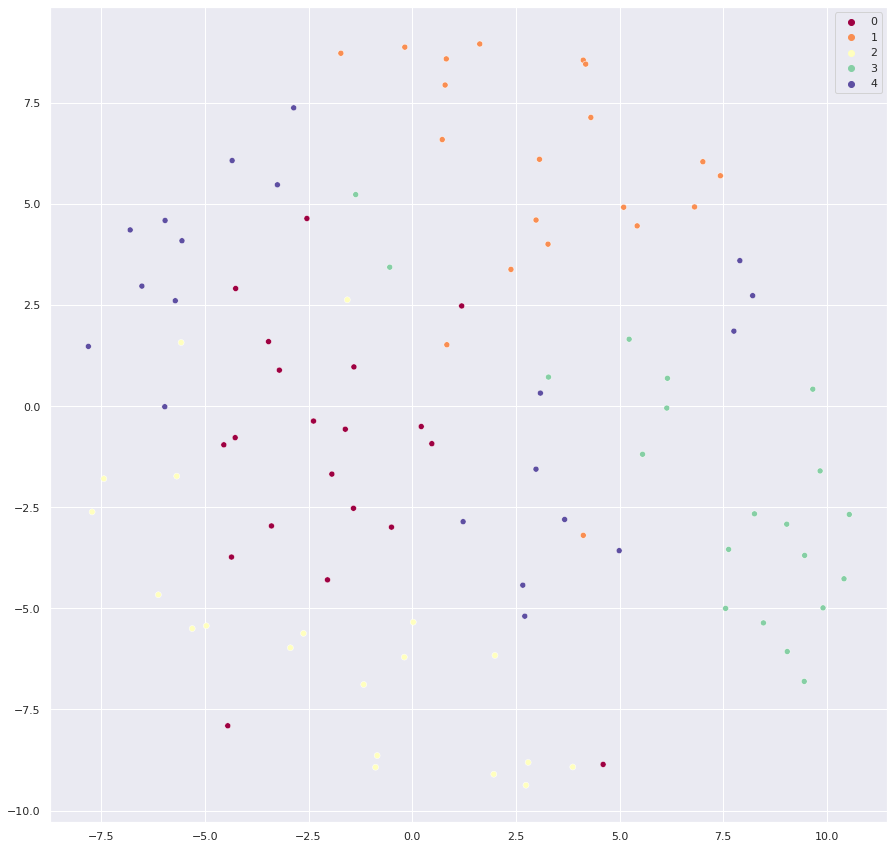

In [72]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend="full")

In [101]:
z_supp, z_query = model.re_represent(z, 25, 0.6, 0.5, 1.)

In [102]:
z = torch.cat([z_supp, z_query])

In [103]:
r = TSNE().fit_transform(z.cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

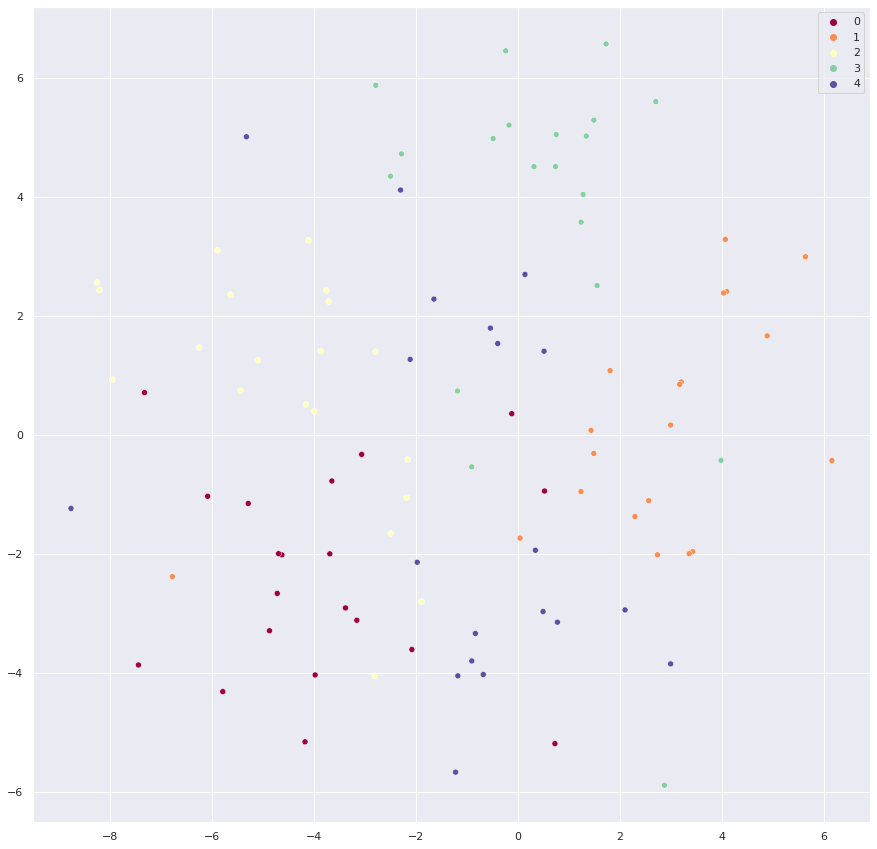

In [104]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend="full")

In [105]:
dl = get_episode_loader("miniimagenet", "/home/ojass/projects/unsupervised-meta-learning/data/untarred/", ways=5, shots=5, test_shots=15, batch_size=1, split="test")

Supervised data loader for miniimagenet:test.


In [106]:
idl = iter(dl)

In [107]:
xs = next(idl)

In [108]:
train = xs["train"]
test = xs["test"]

In [109]:
x_train = train[0][0]

In [110]:
y_train = train[1][0]

In [111]:
y_train

tensor([4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1,
        1])

In [112]:
x_test = test[0][0]
y_test = test[1][0]

In [113]:
x = torch.cat([x_train, x_test])

In [115]:
z = model(x.cuda())

In [70]:
y = torch.cat([y_train, y_test])

In [117]:
r = TSNE().fit_transform(z.cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

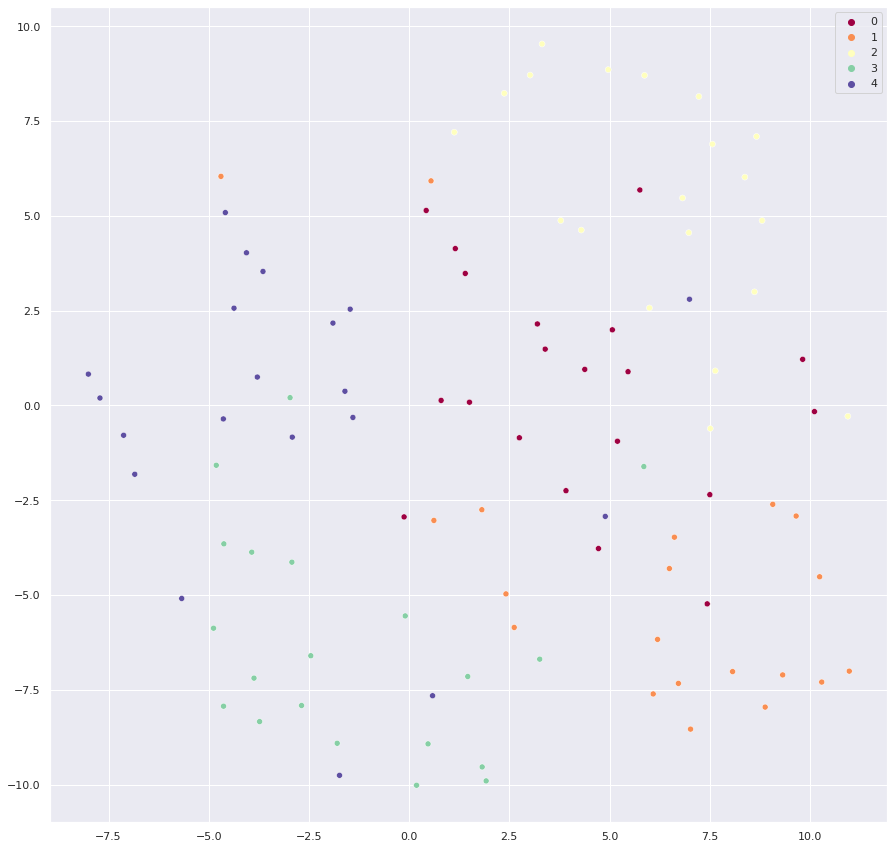

In [118]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend="full")

In [124]:
z_supp, z_query = model.re_represent(z, 25, 0.5, 0.5, 0.1)

In [125]:
z = torch.cat([z_supp, z_query])

In [126]:
r = TSNE().fit_transform(z.cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

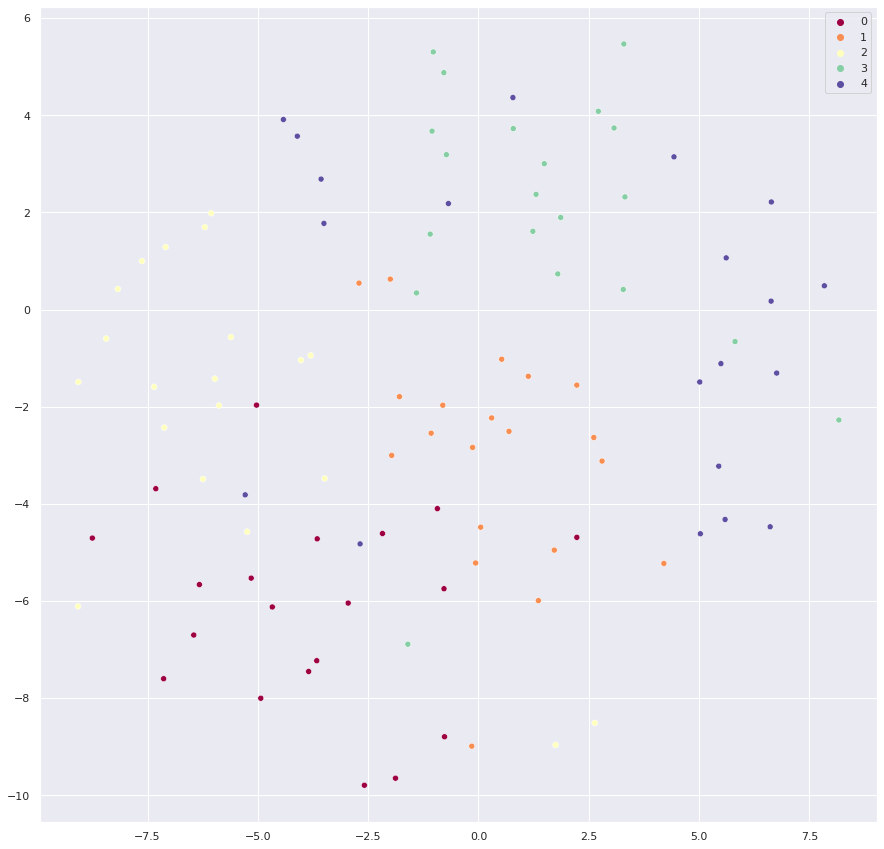

In [128]:
from optimal_transport.sot import SOT

In [177]:
sot = SOT(ot_reg=0.1, sinkhorn_iterations=5)

In [130]:
z = model(x.cuda())

In [183]:
zs = sot.forward(z, n_samples=None , y_support=y_train)

In [184]:
r = TSNE().fit_transform(zs.cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

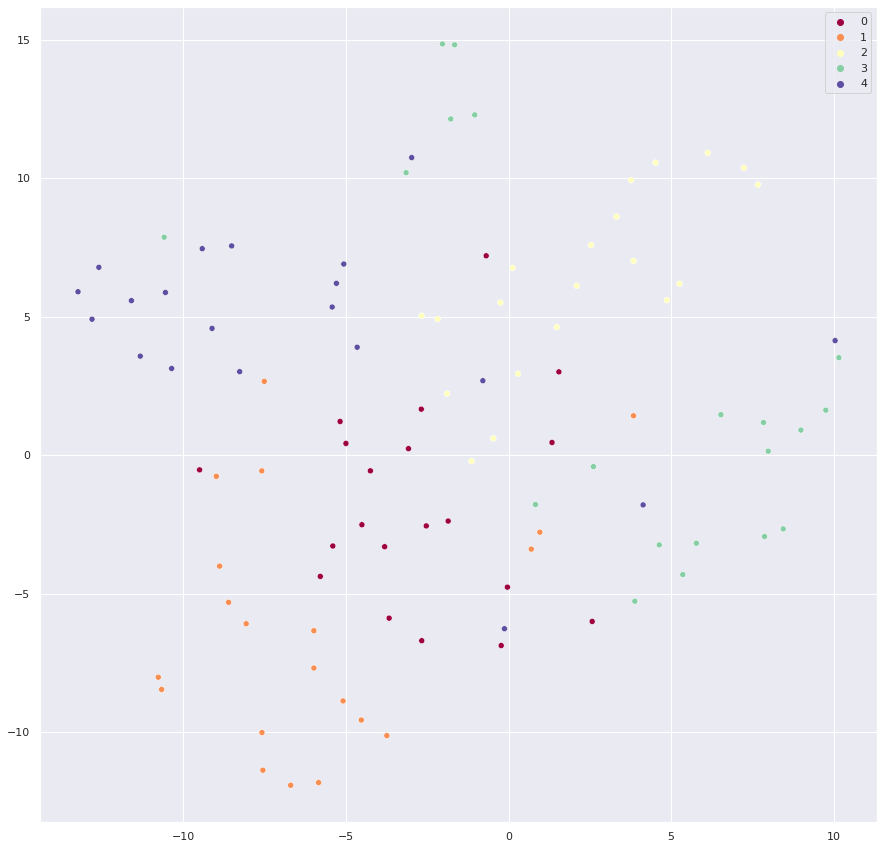

In [185]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend="full")

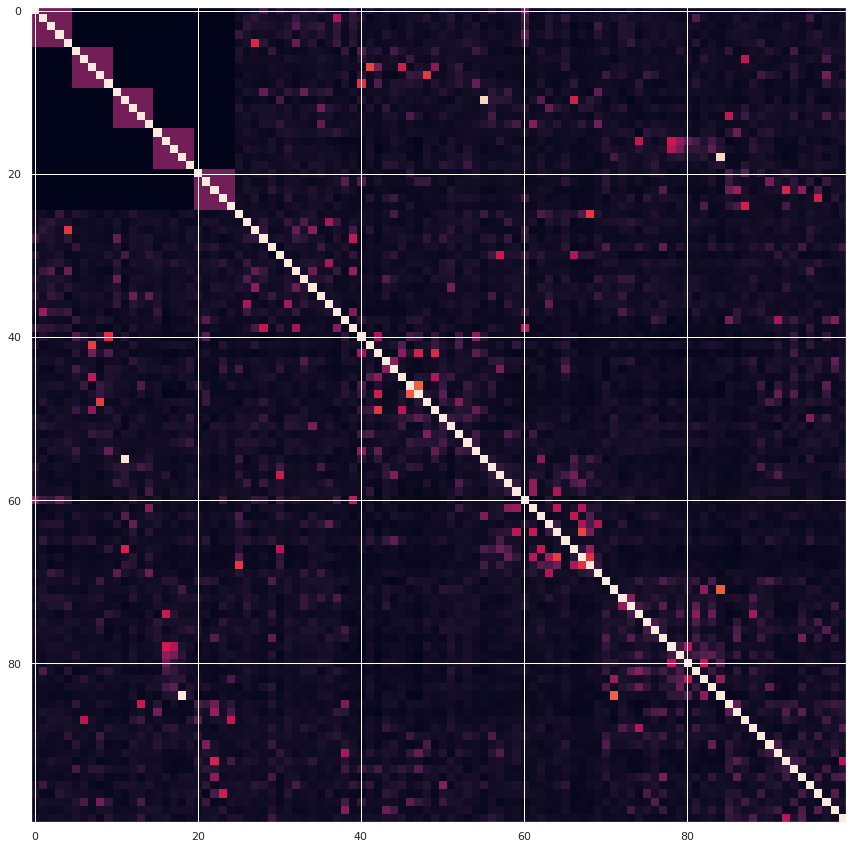

In [181]:
plt.imshow(zs.cpu().detach().numpy())

In [186]:
import numpy as np

In [189]:
rand_id = np.random.permutation(25)

In [190]:
selected_id = torch.from_numpy(rand_id[0: min(0 + batch_size, support_size)])

NameError: name 'j' is not defined

In [1]:
selected_id = [16,  6,  9,  3, 21]